<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDW Method

In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.1 MB/s eta 0:00:00


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 107.9 MB/s eta 0:00:00


# additive IDW

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import time
from scipy.spatial import cKDTree

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')  # Your CSV file
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')  # Model NetCDF file

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].isel(time=0).values.astype(np.float32)  # Remove time dimension

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias (Observed - Modeled)
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# IDW Interpolation Function
def idw_interpolation(grid_lon, grid_lat, stations_data, power=2, num_neighbors=10):
    """Applies Inverse Distance Weighting (IDW) interpolation."""
    station_coords = np.vstack((stations_data['lon'].values, stations_data['lat'].values)).T
    bias_values = stations_data['bias'].values

    # Properly structure the model grid
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat, indexing='xy')
    grid_coords = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create KDTree for nearest neighbor searches
    tree = cKDTree(station_coords)
    distances, indices = tree.query(grid_coords, k=num_neighbors)  # Use 10 nearest neighbors for accuracy

    # Avoid division by zero
    distances[distances == 0] = 1e-10

    # Compute weights using inverse distance
    weights = 1.0 / np.power(distances, power)
    weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

    # Apply IDW formula
    interpolated_bias = np.sum(weights * bias_values[indices], axis=1)

    # Corrected reshaping to match model grid
    return interpolated_bias.reshape(len(grid_lat), len(grid_lon))

# Apply IDW Interpolation
print("Interpolating bias using IDW...")
z_bias = idw_interpolation(model_lons, model_lats, stations_data)

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = xr.Dataset()

# Add the corrected variable (No Time Dimension)
corrected_data["SURF_ug_PM25_rh50_corrected"] = (["lat", "lon"], corrected_values)

# Assign coordinates
corrected_data["lon"] = ("lon", model_lons)
corrected_data["lat"] = ("lat", model_lats)

# Preserve metadata
corrected_data["SURF_ug_PM25_rh50_corrected"].attrs = model_data["SURF_ug_PM25_rh50"].attrs
corrected_data.attrs["description"] = "Bias-corrected PM2.5 using IDW interpolation (No Time Dimension)"

# Save Corrected Data
output_file = 'BaseCase_PERT_PM25_rh50_YEARLY_corrected_no_time.nc'
print(f"Saving corrected NetCDF file as {output_file}...")
corrected_data.to_netcdf(output_file)

# End Timer
end_time = time.time()
print(f"Bias-corrected NetCDF saved as: {output_file}")
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Loading data...
Interpolating bias using IDW...
Applying bias correction to model data...
Saving corrected NetCDF file as BaseCase_PERT_PM25_rh50_YEARLY_corrected_no_time.nc...
Bias-corrected NetCDF saved as: BaseCase_PERT_PM25_rh50_YEARLY_corrected_no_time.nc
Total execution time: 0.95 seconds


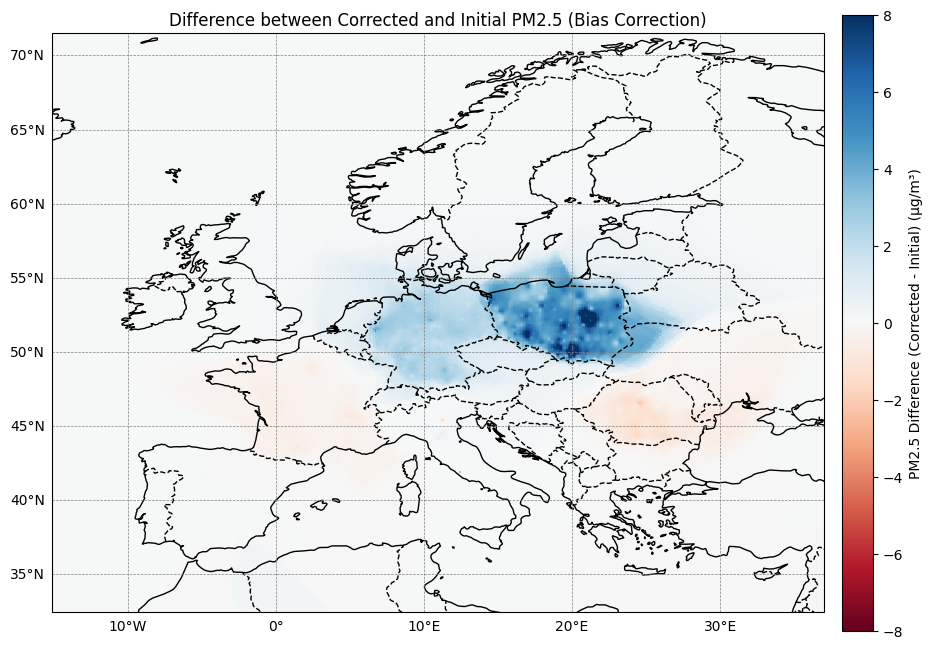

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY_corrected_no_time.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


## Best hyperparameters - search

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.spatial import cKDTree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Load station data
data = pd.read_csv("basePM25nearest_grid.csv")

# Compute bias (Observed - Modeled)
data["PM25_Bias"] = data["SURF_ug_PM25_rh50"] - data["nearest_SURF_ug_PM25_rh50"]

# Extract station locations and bias values
station_coords = data[["lon", "lat"]].values
bias_values = data["PM25_Bias"].values

# Hyperparameter search space
power_values = [1, 2, 3, 4, 5, 10, 15]  # Different weight decay factors
neighbor_values = [5, 10, 15, 20, 25, 30, 35, 40]  # Different nearest neighbor counts

# Set up k-fold cross-validation
kf = KFold(n_splits=50, shuffle=True, random_state=42)

# Store results
results = []

# Perform grid search
for p in power_values:
    for k in neighbor_values:
        errors = []

        for train_index, test_index in kf.split(station_coords):
            # Split training and testing data
            train_coords, test_coords = station_coords[train_index], station_coords[test_index]
            train_bias, test_bias = bias_values[train_index], bias_values[test_index]

            # Build KDTree
            tree = cKDTree(train_coords)
            distances, indices = tree.query(test_coords, k=k)

            # Avoid division by zero
            distances[distances == 0] = 1e-10

            # Compute weights using IDW
            weights = 1.0 / np.power(distances, p)
            weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

            # Predict bias at test locations
            predicted_bias = np.sum(weights * train_bias[indices], axis=1)

            # Compute RMSE
            error = np.sqrt(mean_squared_error(test_bias, predicted_bias))
            errors.append(error)

        # Store mean RMSE for this (p, k) pair
        mean_rmse = np.mean(errors)
        results.append((p, k, mean_rmse))

# Find the best hyperparameter combination
best_p, best_k, best_rmse = min(results, key=lambda x: x[2])
print(f"\nBest hyperparameters: p={best_p}, k={best_k} → RMSE: {best_rmse:.4f}")

# === Load Model Data ===
model_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
ds_model = xr.open_dataset(model_nc)

# Extract Model Data
model_lons = ds_model["lon"].values
model_lats = ds_model["lat"].values
model_values = ds_model["SURF_ug_PM25_rh50"].isel(time=0).values.astype(np.float32)  # Remove time dimension

# === IDW Interpolation Function ===
def idw_interpolation(grid_lon, grid_lat, stations_data, power, num_neighbors):
    """Applies Inverse Distance Weighting (IDW) interpolation."""
    station_coords = np.vstack((stations_data['lon'].values, stations_data['lat'].values)).T
    bias_values = stations_data["PM25_Bias"].values

    # Create grid
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat, indexing='xy')
    grid_coords = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Build KDTree
    tree = cKDTree(station_coords)
    distances, indices = tree.query(grid_coords, k=num_neighbors)

    # Avoid division by zero
    distances[distances == 0] = 1e-10

    # Compute weights using IDW
    weights = 1.0 / np.power(distances, power)
    weights /= weights.sum(axis=1, keepdims=True)

    # Compute interpolated bias
    interpolated_bias = np.sum(weights * bias_values[indices], axis=1)

    # Reshape
    return interpolated_bias.reshape(len(grid_lat), len(grid_lon))

# === Apply IDW with Best Hyperparameters ===
print("\nInterpolating bias using optimized IDW...")
z_bias = idw_interpolation(model_lons, model_lats, data, best_p, best_k)

# Apply Bias Correction
corrected_values = model_values + z_bias
corrected_data = xr.Dataset()

# Add the corrected variable (No Time Dimension)
corrected_data["SURF_ug_PM25_rh50_corrected"] = (["lat", "lon"], corrected_values)

# Assign coordinates
corrected_data["lon"] = ("lon", model_lons)
corrected_data["lat"] = ("lat", model_lats)

# Preserve metadata
corrected_data["SURF_ug_PM25_rh50_corrected"].attrs = ds_model["SURF_ug_PM25_rh50"].attrs
corrected_data.attrs["description"] = f"Bias-corrected PM2.5 using IDW (p={best_p}, k={best_k}) - No Time Dimension"

# Save Corrected Data
output_file = "BaseCase_PERT_PM25_rh50_YEARLY_corrected-2_no_time.nc"
corrected_data.to_netcdf(output_file)
print(f"\nBias-corrected NetCDF saved as: {output_file}")



Best hyperparameters: p=1, k=10 → RMSE: 0.4850

Interpolating bias using optimized IDW...

Bias-corrected NetCDF saved as: BaseCase_PERT_PM25_rh50_YEARLY_corrected-2_no_time.nc


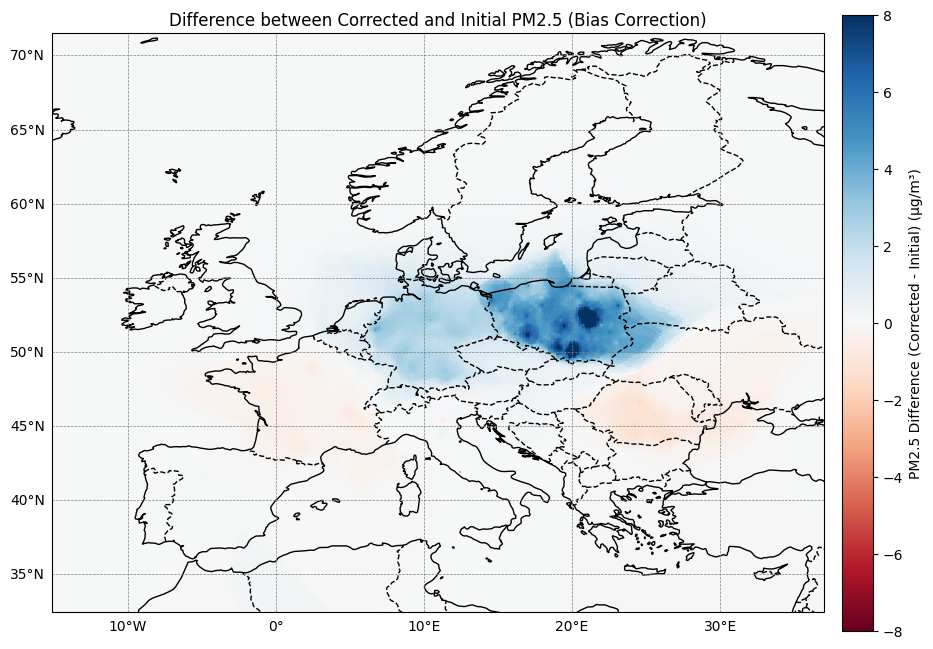

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY_corrected-2_no_time.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW Batch Processing

## chunks = 4

In [ ]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (difference between observed and modeled values)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]  # Remove time dimension

# Create a meshgrid of lat/lon
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points and biases
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === IDW Interpolation Function ===
def idw_interpolation(grid_points, station_points, values, power=2):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=5)  # Consider 5 nearest stations

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** power)
            interpolated[i] = np.sum(weights * values[idxs]) / np.sum(weights)

    return interpolated

# === Perform IDW Interpolation in Small Groups ===
chunks = 4
chunk_size = len(points_grid) // chunks
interpolated_bias_total = np.zeros_like(pm25_modeled.ravel())

# Process each chunk
for chunk_idx in range(chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = (chunk_idx + 1) * chunk_size if chunk_idx < chunks - 1 else len(points_grid)

    chunk_grid_points = points_grid[start_idx:end_idx]
    chunk_interpolated_bias = idw_interpolation(chunk_grid_points, station_points, bias_values)

    interpolated_bias_total[start_idx:end_idx] = chunk_interpolated_bias

# Reshape result to match the grid shape
interpolated_bias_total = interpolated_bias_total.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25 = pm25_modeled + interpolated_bias_total

# === Save the Corrected NetCDF File (No Time Dimension) ===
corrected_netcdf_path = "corrected_pm25-4_no_time.nc"

# Ensure no locked file exists before creating a new one
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)  # Copy attributes
new_dataset.description = "Bias-corrected PM2.5 using IDW interpolation (No Time Dimension)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25

# Close new NetCDF file
new_dataset.close()
dataset.close()

print("Bias correction using IDW in chunks completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


Interpolating IDW: 100%|██████████| 101726/101726 [00:08<00:00, 11400.93grid point/s]

Bias correction using IDW in chunks completed successfully! Corrected NetCDF file saved as corrected_pm25-4_no_time.nc


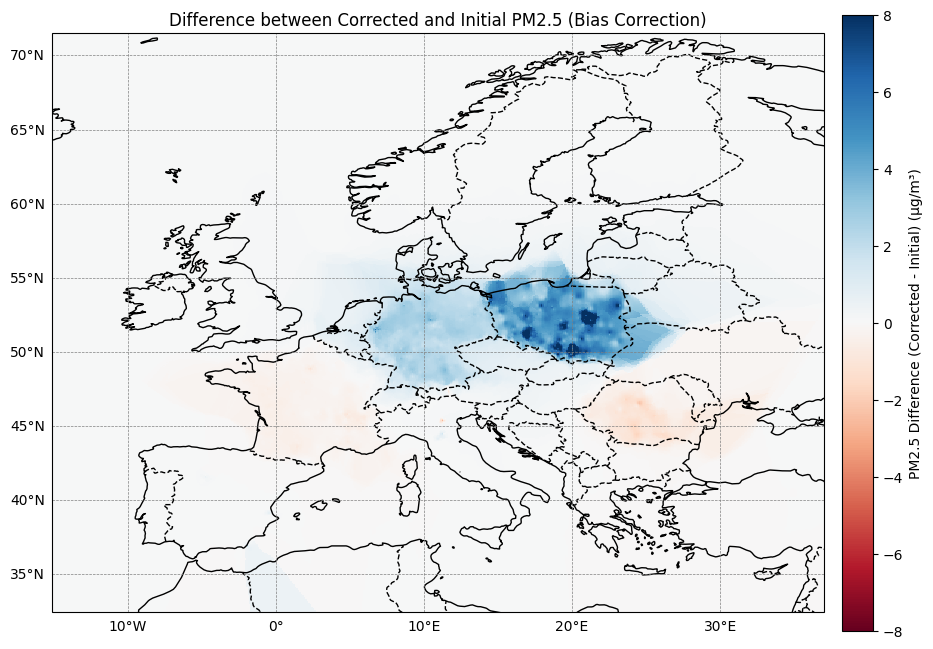

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25-4_no_time.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW Rescaled Additive Method

In [ ]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (difference between observed and modeled values)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]  # Remove time dimension

# Create a meshgrid of lat/lon
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points and biases
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === IDW Rescaled Additive Method ===
def idw_rescaled_additive(grid_points, station_points, values, pm25_modeled, power=2):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Rescaled Additive", unit="grid point"):
        # Find the nearest 5 stations
        dists, idxs = tree.query(grid_points[i], k=5)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** power)  # Inverse distance weights
            # Find the grid indices from the station coordinates with tolerance
            station_lons, station_lats = station_points[idxs].T

            # Use np.argmin to find the closest grid point index
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])

            # Calculate scaling factor for rescaled additive correction
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)
            interpolated[i] = scaling_factor * np.sum(weights * values[idxs]) / np.sum(weights)

    return interpolated

# === Perform IDW Rescaled Additive Interpolation ===
print("\nInterpolating bias using IDW Rescaled Additive method...")
interpolated_bias_rescaled = idw_rescaled_additive(points_grid, station_points, bias_values, pm25_modeled)

# Reshape the result to match the grid shape
interpolated_bias_rescaled = interpolated_bias_rescaled.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_rescaled = pm25_modeled + interpolated_bias_rescaled

# === Save the Corrected NetCDF File (No Time Dimension) ===
corrected_netcdf_path = "corrected_pm25_rescaled_no_time.nc"

# Ensure no locked file exists before creating a new one
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)  # Copy attributes
new_dataset.description = "Bias-corrected PM2.5 using IDW Rescaled Additive (No Time Dimension)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_rescaled

# Close new NetCDF file
new_dataset.close()
dataset.close()

print("Bias correction using IDW Rescaled Additive method completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)



Interpolating bias using IDW Rescaled Additive method...


Interpolating IDW Rescaled Additive: 100%|██████████| 406901/406901 [07:38<00:00, 886.60grid point/s]


Bias correction using IDW Rescaled Additive method completed successfully! Corrected NetCDF file saved as corrected_pm25_rescaled_no_time.nc


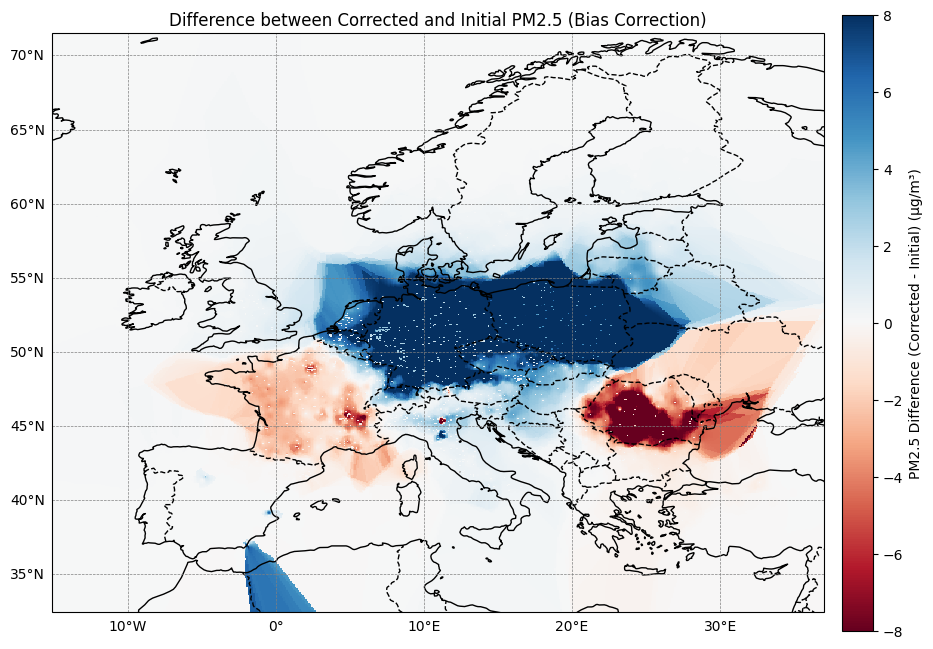

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_rescaled_no_time.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


In [ ]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute the bias ratio (Multiplicative factor: Observed / Modeled)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
df.dropna(subset=["bias_ratio"], inplace=True)  # Drop NaN values

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]  # Remove time dimension

# Create a meshgrid of lat/lon
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points and bias ratios
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_ratios = df["bias_ratio"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === IDW Multiplicative Method ===
def idw_multiplicative(grid_points, station_points, values, power=2):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Multiplicative", unit="grid point"):
        # Find the nearest 5 stations
        dists, idxs = tree.query(grid_points[i], k=5)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** power)  # Inverse distance weights
            interpolated[i] = np.sum(weights * values[idxs]) / np.sum(weights)  # Weighted average

    return interpolated

# === Perform IDW Multiplicative Interpolation ===
print("\nInterpolating bias ratio using IDW Multiplicative method...")
interpolated_bias_ratio = idw_multiplicative(points_grid, station_points, bias_ratios)

# Reshape the result to match the grid shape
interpolated_bias_ratio = interpolated_bias_ratio.reshape(pm25_modeled.shape)

# Apply multiplicative correction
corrected_pm25_mul = pm25_modeled * interpolated_bias_ratio

# === Save the Corrected NetCDF File (No Time Dimension) ===
corrected_netcdf_path = "corrected_pm25_multiplicative_no_time.nc"

# Ensure no locked file exists before creating a new one
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)  # Copy attributes
new_dataset.description = "Bias-corrected PM2.5 using IDW Multiplicative (No Time Dimension)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_mul

# Close new NetCDF file
new_dataset.close()
dataset.close()

print("Bias correction using IDW Multiplicative method completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


<ipython-input-4-044cd8c82b83>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities



Interpolating bias ratio using IDW Multiplicative method...


Interpolating IDW Multiplicative: 100%|██████████| 406901/406901 [00:21<00:00, 18536.03grid point/s]

Bias correction using IDW Multiplicative method completed successfully! Corrected NetCDF file saved as corrected_pm25_multiplicative_no_time.nc


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


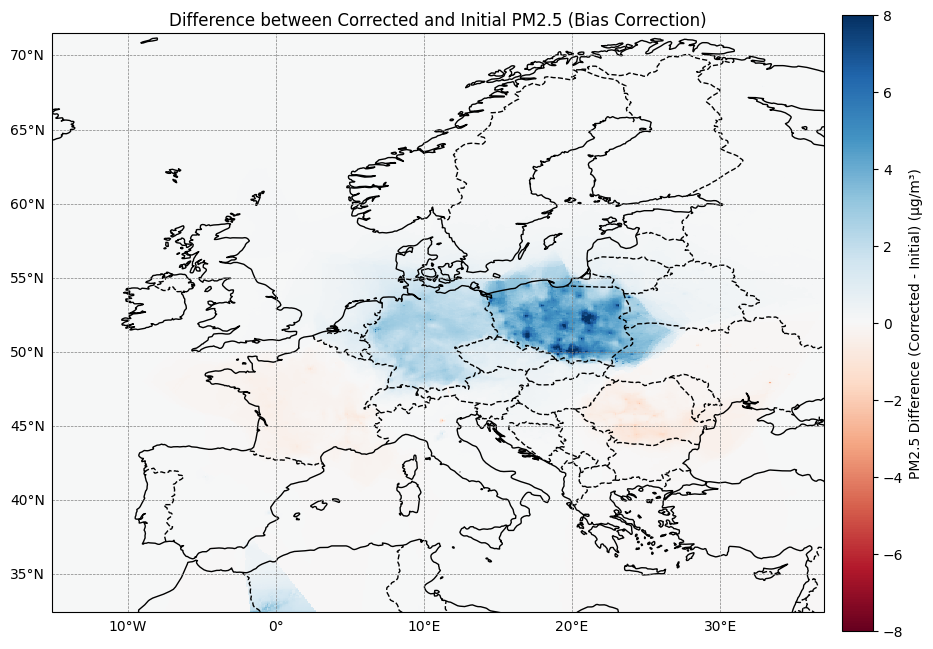

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_multiplicative_no_time.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
